# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from PIL import Image

import torch
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.applications import EfficientNetB0

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

/opt/anaconda3/envs/ml-env/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


Current data directory: /Users/hank/Documents/flatiron_school/foundations/c6/m8/RealWaste
Directory: Paper
  - Image count: 500
  - Resolution: (524, 524)

Directory: Metal
  - Image count: 790
  - Resolution: (524, 524)

Directory: Cardboard
  - Image count: 461
  - Resolution: (524, 524)

Directory: Food Organics
  - Image count: 411
  - Resolution: (524, 524)

Directory: Glass
  - Image count: 420
  - Resolution: (524, 524)

Directory: Vegetation
  - Image count: 436
  - Resolution: (524, 524)

Directory: Textile Trash
  - Image count: 318
  - Resolution: (524, 524)

Directory: Miscellaneous Trash
  - Image count: 495
  - Resolution: (524, 524)

Directory: Plastic
  - Image count: 921
  - Resolution: (524, 524)

Class information dictionary:
{'Paper': {'count': 500, 'resolution': (524, 524)}, 'Metal': {'count': 790, 'resolution': (524, 524)}, 'Cardboard': {'count': 461, 'resolution': (524, 524)}, 'Food Organics': {'count': 411, 'resolution': (524, 524)}, 'Glass': {'count': 420, 'res

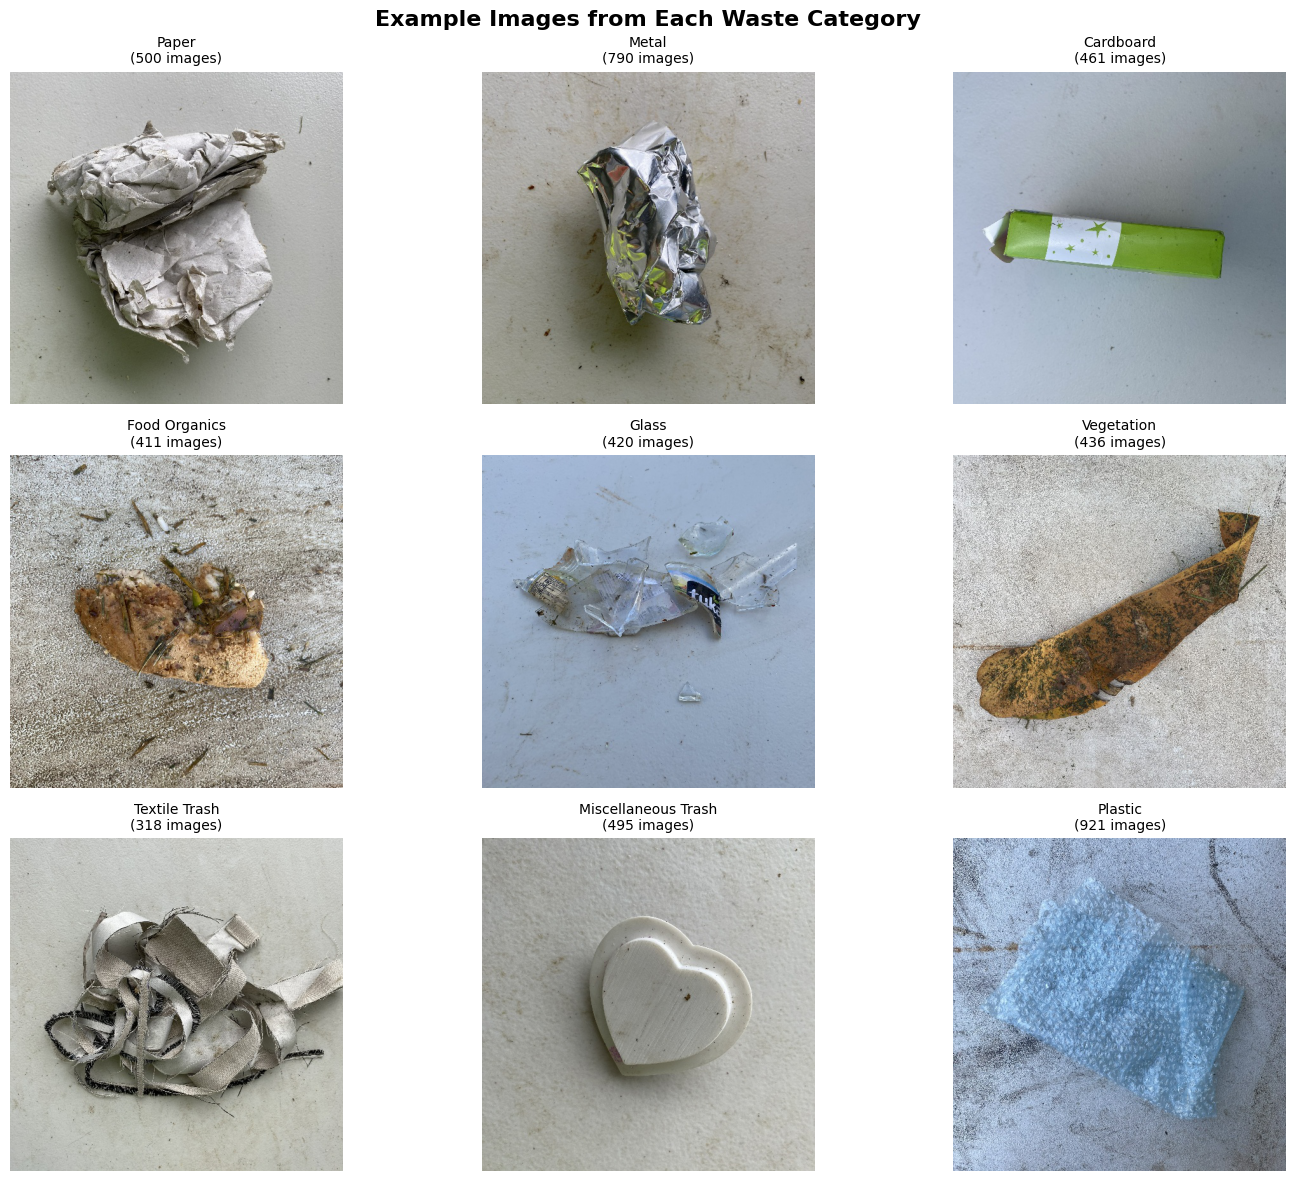

In [2]:
# Load and explore the RealWaste dataset
# Dataset structure
# Distribution of waste categories
# Image characteristics (resolution, quality, background)

# Create empty dictionary for class information
class_info = {}

# Scan the working directory for subdirectories

# Get current working directory
data_dir = os.getcwd() + "/RealWaste"
print(f"Current data directory: {data_dir}")

# Scan for subdirectories
for item in os.listdir(data_dir):
    item_path = os.path.join(data_dir, item)
    if os.path.isdir(item_path):
        # Count images in the subdirectory
        image_count = 0
        image_files = []
        
        # Look for common image extensions
        for file in os.listdir(item_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                image_count += 1
                image_files.append(file)
        
        # Get resolution of first image if any exist
        resolution = None
        if image_files:
            try:
                first_image_path = os.path.join(item_path, image_files[0])
                with Image.open(first_image_path) as img:
                    resolution = img.size  # Returns (width, height)
            except Exception as e:
                print(f"Error reading image {image_files[0]} in {item}: {e}")
                resolution = "Unknown"
        
        # Create entry in class_info dictionary
        class_info[item] = {
            'count': image_count,
            'resolution': resolution
        }
        
        print(f"Directory: {item}")
        print(f"  - Image count: {image_count}")
        print(f"  - Resolution: {resolution}")
        print()

print("Class information dictionary:")
print(class_info)

# Display a single example image from each class
plt.figure(figsize=(15, 12))
plt.suptitle('Example Images from Each Waste Category', fontsize=16, fontweight='bold')

# Calculate grid dimensions (3 columns, adjust rows as needed)
num_classes = len(class_info)
cols = 3
rows = (num_classes + cols - 1) // cols  # Ceiling division

for idx, (class_name, info) in enumerate(class_info.items()):
    if info['count'] > 0:  # Only process classes with images
        plt.subplot(rows, cols, idx + 1)
        
        # Get the first image from the class directory
        class_path = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        
        if image_files:
            # Load and display the first image
            first_image_path = os.path.join(class_path, image_files[0])
            img = Image.open(first_image_path)
            
            plt.imshow(img)
            plt.title(f'{class_name}\n({info["count"]} images)', fontsize=10)
            plt.axis('off')

plt.tight_layout()
plt.show()

### 1.2 Explore Text Datasets

                                         description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3           

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Textile Trash'),
  Text(1, 0, 'Glass'),
  Text(2, 0, 'Food Organics'),
  Text(3, 0, 'Plastic'),
  Text(4, 0, 'Vegetation'),
  Text(5, 0, 'Cardboard'),
  Text(6, 0, 'Metal'),
  Text(7, 0, 'Paper'),
  Text(8, 0, 'Miscellaneous Trash')])

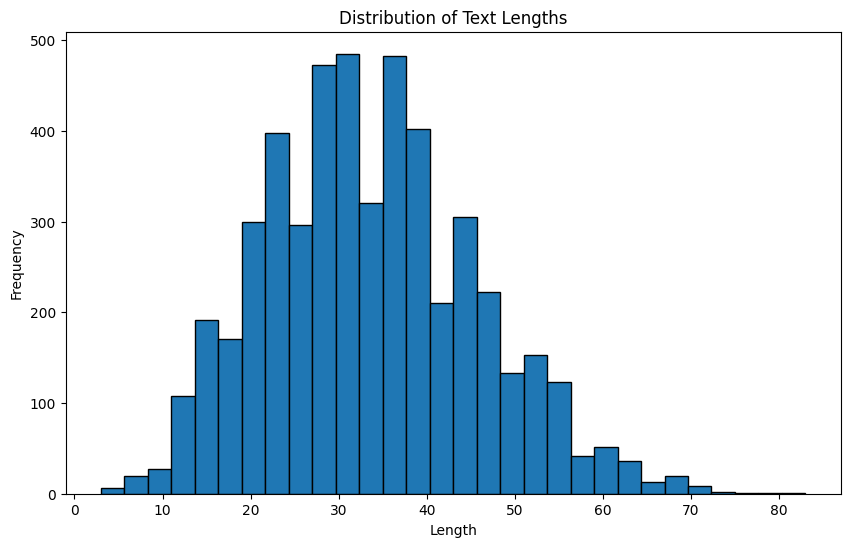

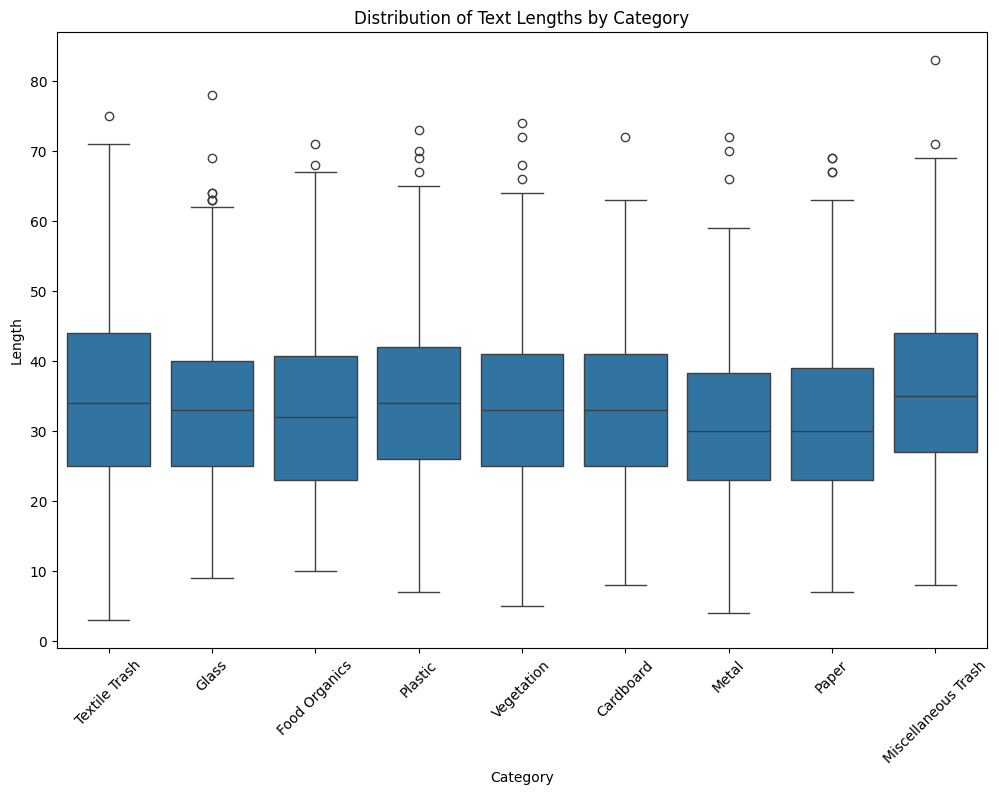

In [15]:
# TODO: Load and explore the waste description text data
# - Load waste_descriptions.csv
# - Analyze vocabulary and structure
# - Understand the distribution of categories

descriptions_df = pd.read_csv('waste_descriptions.csv')

# Analyze vocabulary and structure
print(descriptions_df.head())
print('--------------------------------')
print(descriptions_df.info())
print('--------------------------------')
print(descriptions_df.describe())
print('--------------------------------')
#check for missing values
print(descriptions_df.isnull().sum())
print('--------------------------------')
#check for duplicates
print(descriptions_df.duplicated().sum())
# Understand the distribution of categories
print(descriptions_df['category'].value_counts())
print('--------------------------------')
# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(descriptions_df['description'].str.len(), bins=30, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

categories = descriptions_df['category'].unique()

#Plot the distribution of text length by category
descriptions_df['description_length'] = descriptions_df['description'].str.len()
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='description_length', data=descriptions_df)
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Category')
plt.ylabel('Length')
plt.xticks(rotation=45)


In [24]:
# TODO: Load and explore the waste policy documents
# - Load waste_policy_documents.csv
# - Understand document organization and language

# load waste policy documents from json file
waste_policy_df = pd.read_json('waste_policy_documents.json')

# Understand document organization and language
print(waste_policy_df.head())
print('--------------------------------')
print(waste_policy_df.info())
print('--------------------------------')
print(waste_policy_df.describe())
print('--------------------------------')
print(waste_policy_df.isnull().sum())
print('--------------------------------')

print(waste_policy_df.iloc[0]['document_text'])
print('--------------------------------')
print(waste_policy_df.iloc[1]['document_text'])
print('--------------------------------')
print(waste_policy_df.iloc[2]['document_text'])
print('--------------------------------')



   policy_id                         policy_type categories_covered  \
0          1  Textile Trash Recycling Guidelines    [Textile Trash]   
1          2          Glass Recycling Guidelines            [Glass]   
2          3  Food Organics Recycling Guidelines    [Food Organics]   
3          4        Plastic Recycling Guidelines          [Plastic]   
4          5     Vegetation Recycling Guidelines       [Vegetation]   

  effective_date                                      document_text  \
0     2023-11-04  TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...   
1     2023-01-24  GLASS RECYCLING GUIDELINES\n\nAcceptable Items...   
2     2023-05-08  FOOD ORGANICS RECYCLING GUIDELINES\n\nAcceptab...   
3     2023-04-05  PLASTIC RECYCLING GUIDELINES\n\nAcceptable Ite...   
4     2023-12-04  VEGETATION RECYCLING GUIDELINES\n\nAcceptable ...   

  jurisdiction  
0   Metro City  
1   Metro City  
2   Metro City  
3   Metro City  
4   Metro City  
--------------------------------
<class 'pan

### 1.3 Create Data Pipelines

In [4]:
# Run this code to setup the images properly into train, validation, and test sets
# Set your data directory path - update this with your actual path
import pathlib
data_dir = pathlib.Path('RealWaste')

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Calculate the total number of classes automatically from the directory structure
num_classes = len([item for item in data_dir.glob('*') if item.is_dir()])
print(f"Number of classes: {num_classes}")

# List all class folders
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Class names: {class_names}")

# Count all images
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images found: {image_count}")

# Create a dataset using tf.keras.utils.image_dataset_from_directory
# This will automatically split the data into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For one-hot encoded labels
    shuffle=True
)

# Create a separate test dataset by taking part of the validation set
# First, let's get the number of batches in the validation set
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images found: 4752
Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Number of training batches: 119
Number of validation batches: 15
Number of test batches: 15


In [5]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

def clean_text_df(df):
    clean_df = df.copy()
    # drop duplicates
    # clean_df = clean_df.drop_duplicates()

    # One hot encode the categories as 'label'
    category_mapping = {category: i for i, category in enumerate(clean_df['category'].unique())}
    clean_df['label'] = clean_df['category'].map(category_mapping)

    return clean_df

def text_ttv_split(df):
    # Split data into train, val, and test
    train_val_df, text_test_df = train_test_split(df, test_size=0.2, stratify=descriptions_df['category'], random_state=42)
    # Then split train+validation into separate train and validation sets
    text_train_df, text_val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['category'], random_state=42)

    return text_train_df, text_val_df, text_test_df

In [5]:
os.environ['TF_USE_LEGACY_KERAS']= '1'

# Select and load BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# Create TensorFlow datasets
def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts.to_numpy(), labels.to_numpy()))
    if shuffle:
        dataset = dataset.shuffle(len(texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [6]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

# functino for creating document embeddings
def create_document_embeddings(documents):
    """
    Create embeddings for a list of documents.
    
    Args:
        documents: List of text documents to embed
        
    Returns:
        Numpy array of document embeddings
    """
    # Initialize a sentence transformer model
    # Recommended: 'sentence-transformers/all-mpnet-base-v2' or similar
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # Replace with your code
    
    # Generate embeddings for all documents
    # Hint: Use the model.encode() method
    document_embeddings = embedding_model.encode(documents, 
                                            show_progress_bar=True)  # Replace with your code
    
    return document_embeddings

## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [ ]:
# TODO: Implement image preprocessing
# - Apply the preprocessing pipeline created earlier

# The preprocessing already happened in the cell above  with provided preprocessing code

### 2.2 Implement CNN Model with Transfer Learning

In [7]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
# load the base model EfficientNetB0
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model, assuming it has learned relevant features
base_model.trainable = False

# Add a global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Add Dropout Layer

dropout_layer = tf.keras.layers.Dropout(0.3)

# Add a dense layer with 9 units and a softmax activation function
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Create the final model
cv_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dropout_layer,
    prediction_layer
])

### 2.3 Train and Evaluate the Model

In [8]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

cv_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

cv_history = cv_model.fit(train_ds,
          validation_data=validation_ds,
          epochs=10)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.3461 - loss: 1.8755 - precision: 0.5278 - recall: 0.1397 - val_accuracy: 0.5255 - val_loss: 1.3676 - val_precision: 0.6818 - val_recall: 0.3191
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 258ms/step - accuracy: 0.4776 - loss: 1.4479 - precision: 0.6406 - recall: 0.2912 - val_accuracy: 0.5553 - val_loss: 1.2353 - val_precision: 0.7273 - val_recall: 0.4085
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 36s 301ms/step - accuracy: 0.5300 - loss: 1.3081 - precision: 0.6841 - recall: 0.3503 - val_accuracy: 0.5766 - val_loss: 1.1881 - val_precision: 0.6890 - val_recall: 0.4149
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 37s 314ms/step - accuracy: 0.5537 - loss: 1.2244 - precision: 0.7030 - recall: 0.3803 - val_accuracy: 0.5787 - val_loss: 1.1329 - val_precision: 0.7003 - val_recall: 0.4426
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - accuracy: 0.5715 - loss: 1.1701 - precision: 0.7245 - recall: 0.4066 - val_accuracy: 0.5830

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step


<Figure size 1000x800 with 0 Axes>

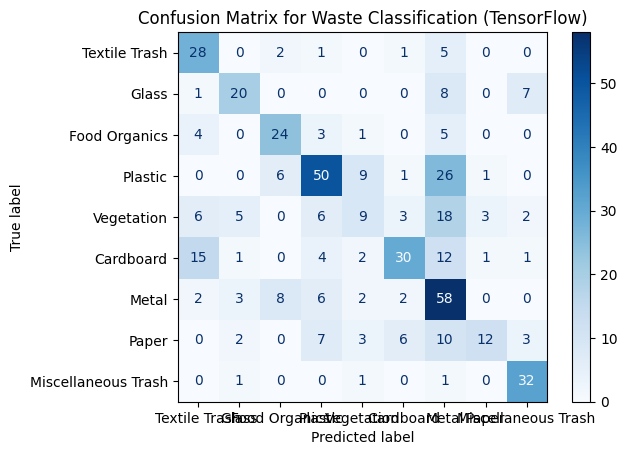


Classification Report:
                     precision    recall  f1-score   support

      Textile Trash       0.50      0.76      0.60        37
              Glass       0.62      0.56      0.59        36
      Food Organics       0.60      0.65      0.62        37
            Plastic       0.65      0.54      0.59        93
         Vegetation       0.33      0.17      0.23        52
          Cardboard       0.70      0.45      0.55        66
              Metal       0.41      0.72      0.52        81
              Paper       0.71      0.28      0.40        43
Miscellaneous Trash       0.71      0.91      0.80        35

           accuracy                           0.55       480
          macro avg       0.58      0.56      0.54       480
       weighted avg       0.57      0.55      0.53       480



In [16]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

categories = descriptions_df['category'].unique()

all_features = []
all_labels = []

# Iterate through the dataset
for features_batch, labels_batch in test_dataset:
    all_features.append(features_batch.numpy())
    all_labels.append(labels_batch.numpy())

# Convert lists to NumPy arrays
features_for_evaluation = np.concatenate(all_features, axis=0)
labels_for_evaluation = np.concatenate(all_labels, axis=0)

cv_test_predictions = cv_model.predict(features_for_evaluation)
cv_y_pred = cv_test_predictions.argmax(axis=1)

cv_y_true = np.argmax(labels_for_evaluation, axis=1)

# Create and visualize the confusion matrix
cm = confusion_matrix(cv_y_true, cv_y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Waste Classification (TensorFlow)')
plt.grid(False)
plt.show()

# Create classification report
report_str = classification_report(cv_y_true, cv_y_pred, target_names=categories)
report = classification_report(cv_y_true, cv_y_pred, target_names=categories, output_dict=True)
print("\nClassification Report:")
print(report_str)

### 2.4 Fine-tune the Model

In [ ]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed

# Your code here

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [10]:
# TODO: Implement text preprocessing
# - Apply the text preprocessing pipeline created earlier

clean_df = clean_text_df(descriptions_df)
text_train_df, text_val_df, text_test_df = text_ttv_split(clean_df)

# Convert pandas DataFrames to TensorFlow datasets
train_dataset = create_tf_dataset(text_train_df['description'], text_train_df['label'])
val_dataset = create_tf_dataset(text_val_df['description'], text_val_df['label'])
# Make sure to not shuffle for test data
test_dataset = create_tf_dataset(text_test_df['description'], text_test_df['label'], shuffle=False)

### 3.2 Implement Text Classification Model

In [3]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)

# Make sure to set legacy Keras to work with TF Hub BERT before you import

# Make sure to set legacy Keras to work with TF Hub BERT before you import
import os
os.environ['TF_USE_LEGACY_KERAS']= '1'


# Import TensorFlow-specific libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Select and load BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# Create TensorFlow datasets
def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts.to_numpy(), labels.to_numpy()))
    if shuffle:
        dataset = dataset.shuffle(len(texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Build the BERT model
def build_tf_classifier_model():
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocessing layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    # BERT encoder - set trainable=True for fine-tuning
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Use the pooled output for classification
    net = outputs['pooled_output']

    # Add dropout for regularization
    net = tf.keras.layers.Dropout(0.1)(net)

    # Add classification layer (for 9 categories)
    net = tf.keras.layers.Dense(9, activation='linear', name='classifier')(net)

    # Create model
    model = tf.keras.Model(text_input, net)
    return model

# Create model
tf_classifier_model = build_tf_classifier_model()
tf_classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [11]:
# Compile the model
# Using sparse categorical crossentropy since our labels are integers
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select accuracy as metric
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Set up learning rate and optimizer
init_lr = .0005
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=init_lr)

# Compile the model
tf_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Set up early stopping callback based on validation accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

### 3.3 Train and Evaluate the Model

In [12]:
# TODO: Train the text classification model
# - Use appropriate training parameters
# - Monitor training progress

# Train the model for 5 epochs (not enough epochs most likely but to save on time)
print('Fine-tuning BERT model...')
history = tf_classifier_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stopping]
)

Fine-tuning BERT model...
Epoch 1/5
94/94 [==============================] - 161s 2s/step - loss: 1.0058 - accuracy: 0.6417 - val_loss: 0.1908 - val_accuracy: 0.9570
Epoch 2/5
94/94 [==============================] - 172s 2s/step - loss: 0.1000 - accuracy: 0.9753 - val_loss: 0.0526 - val_accuracy: 0.9870
Epoch 3/5
94/94 [==============================] - 171s 2s/step - loss: 0.1051 - accuracy: 0.9747 - val_loss: 0.0903 - val_accuracy: 0.9820
Epoch 4/5
94/94 [==============================] - 195s 2s/step - loss: 0.1243 - accuracy: 0.9740 - val_loss: 0.0895 - val_accuracy: 0.9820
Epoch 5/5
94/94 [==============================] - 215s 2s/step - loss: 0.1650 - accuracy: 0.9650 - val_loss: 0.0944 - val_accuracy: 0.9810


32/32 [==============================] - 16s 492ms/step - loss: 0.0396 - accuracy: 0.9870
Test accuracy (TensorFlow): 0.987
32/32 [==============================] - 19s 561ms/step


2025-09-20 22:20:04.312207: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

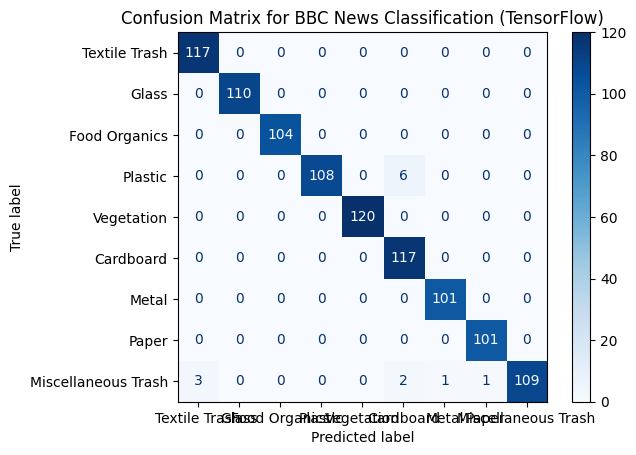


Classification Report:
                     precision    recall  f1-score   support

      Textile Trash       0.97      1.00      0.99       117
              Glass       1.00      1.00      1.00       110
      Food Organics       1.00      1.00      1.00       104
            Plastic       1.00      0.95      0.97       114
         Vegetation       1.00      1.00      1.00       120
          Cardboard       0.94      1.00      0.97       117
              Metal       0.99      1.00      1.00       101
              Paper       0.99      1.00      1.00       101
Miscellaneous Trash       1.00      0.94      0.97       116

           accuracy                           0.99      1000
          macro avg       0.99      0.99      0.99      1000
       weighted avg       0.99      0.99      0.99      1000


Model Strengths and Weaknesses:

Strengths:
- Overall accuracy: 0.9870
- Best performing category: Glass

Weaknesses:
- Worst performing category: Cardboard


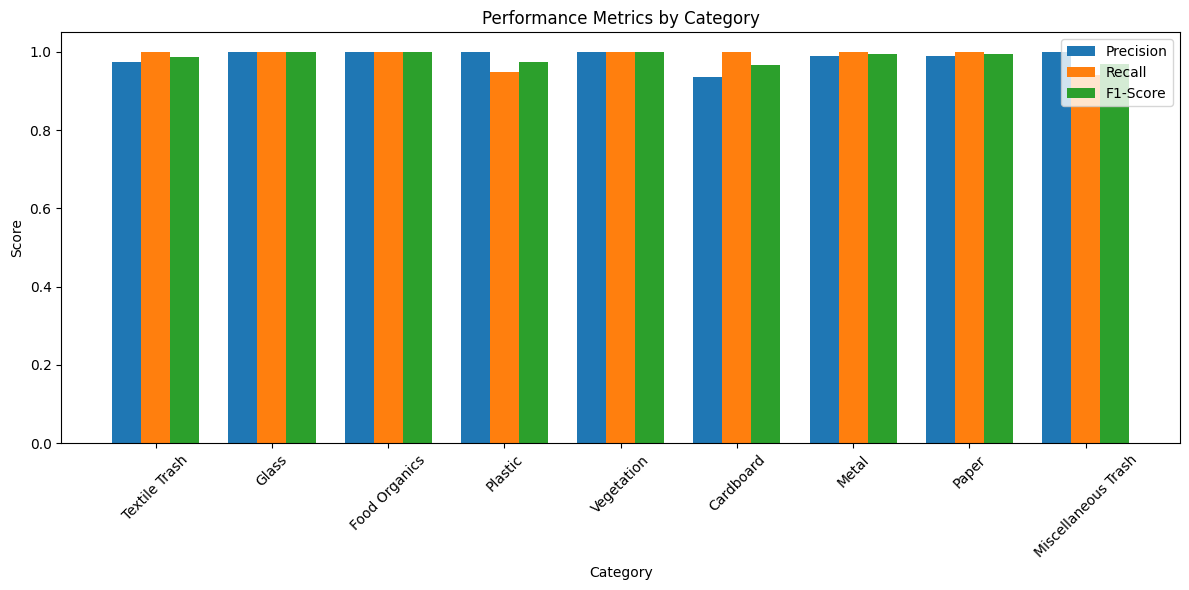

In [13]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

# Evaluate model on testing data
test_loss, test_accuracy = tf_classifier_model.evaluate(test_dataset)
print(f'Test accuracy (TensorFlow): {test_accuracy:.3f}')

# Generate predictions for the test set
test_predictions = tf_classifier_model.predict(test_dataset)
y_pred = test_predictions.argmax(axis=1)

# Get true labels from tensorflow dataset testing data
y_true = [labels.numpy() for _, labels in test_dataset.unbatch()]

# Create and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (TensorFlow)')
plt.grid(False)
plt.show()

# Create classification report
report_str = classification_report(y_true, y_pred, target_names=categories)
report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
print("\nClassification Report:")
print(report_str)

# Identify strengths and weaknesses
print("\nModel Strengths and Weaknesses:")

# Calculate per-class metrics (use classification report)
per_class_metrics = {}
for category in categories:
    per_class_metrics[category] = {
        'precision': report[category]['precision'],
        'recall': report[category]['recall'],
        'f1-score': report[category]['f1-score']
    }

# Find best and worst performing categories
best_category = max(per_class_metrics, key=lambda x: per_class_metrics[x]['f1-score'])
worst_category = min(per_class_metrics, key=lambda x: per_class_metrics[x]['f1-score'])

print(f"\nStrengths:")
print(f"- Overall accuracy: {report['accuracy']:.4f}")
print(f"- Best performing category: {best_category}")
print(f"\nWeaknesses:")
print(f"- Worst performing category: {worst_category}")

# Visualize per-class performance
plt.figure(figsize=(12, 6))
categories_indices = range(len(categories))
width = 0.25

plt.bar([i - width for i in categories_indices],
        [per_class_metrics[cat]['precision'] for cat in categories],
        width=width, label='Precision')
plt.bar(categories_indices,
        [per_class_metrics[cat]['recall'] for cat in categories],
        width=width, label='Recall')
plt.bar([i + width for i in categories_indices],
        [per_class_metrics[cat]['f1-score'] for cat in categories],
        width=width, label='F1-Score')

plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Performance Metrics by Category')
plt.xticks(categories_indices, categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 3.4 Create Classification Function

In [14]:
# TODO: Create a function that takes a text description and returns the predicted waste category

def classify_waste_description(description):
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item

    Returns:
        str: Predicted waste category
    """
    # Your code here
    prediction = tf_classifier_model.predict([description])[0]

    # Get the predicted category and confidence
    predicted_class_id = np.argmax(prediction)
    return categories[predicted_class_id]

## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [26]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval

# Extract document content
documents = waste_policy_df['document_text'].tolist()

# Create document embeddings
document_embeddings = create_document_embeddings(documents)

# Verify the shape of embeddings
if document_embeddings is not None:
    print(f"Generated embeddings with shape: {document_embeddings.shape}")
else:
    print("Embeddings not created yet.")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings with shape: (14, 768)


### 4.2 Implement RAG-based System

In [ ]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism

def retrieve_documents(query, embeddings, contents, categories_covered, top_k=3, threshold=0.3):
    """
    Retrieve the most relevant documents for a given query.
    
    Args:
        query: The material to recycle
        embeddings: The precomputed document embeddings
        contents: The text content of the documents
        categories_covered: The categories addressed for each document
        top_k: Maximum number of documents to retrieve
        threshold: Minimum similarity score to include a document
        
    Returns:
        List of (content, metadata, similarity_score) tuples
    """
    # Get or initialize the embedding model (same as in create_document_embeddings)
    embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # Replace with your code
    
    # Embed the query
    query_embedding = embedding_model.encode([query])[0]  # Replace with your code
    
    # Calculate similarity scores between query and all documents
    # Hint: Use cosine_similarity
    similarities = cosine_similarity([query_embedding], embeddings)[0]  # Replace with your code
    
    # Filter by threshold and get top k results
    # Hint: Use list comprehension, sorting, and slicing
    filtered_indices = [i for i, score in enumerate(similarities) if score >= threshold]
    top_indices = sorted(filtered_indices, key=lambda i: similarities[i], reverse=True)[:top_k]
    
    # Return the top documents with their metadata and scores
    results = [(contents[i], categories_covered[i], similarities[i]) for i in top_indices]  # Replace with your code
    
    return results

# Initialize the generative model
def initialize_generator(model_name="gpt2"):
    """
    Initialize the generative model and tokenizer.
    
    Args:
        model_name: Name of the pretrained model to use
        
    Returns:
        Tokenizer and model objects
    """
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)  # Replace with your code
    model = AutoModelForCausalLM.from_pretrained(model_name)  # Replace with your code
    
    # Set padding token if needed
    # Check if pad_token exists, if not set it to eos_token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    return tokenizer, model

tokenizer, rag_model = initialize_generator()
if tokenizer and rag_model:
    print(f"Initialized {rag_model.config._name_or_path} with {rag_model.num_parameters()} parameters")

def generate_rag_response(query, contents, categories_covered, document_embeddings, tokenizer, model, max_length=100):
    """
    Generate a response using Retrieval-Augmented Generation.
    
    Args:
        query: The material to recycle
        contents: List of document contents
        categories_covered: List of categories addressed by document
        document_embeddings: Precomputed embeddings for the documents
        tokenizer: The tokenizer for the language model
        model: The language model for generation
        max_length: Maximum response length
        
    Returns:
        Dictionary with the generated response and the retrieved documents
    """
    # Retrieve relevant documents for the query
    retrieved_docs = retrieve_documents(
        query, 
        document_embeddings, 
        contents, 
        categories_covered, 
        top_k=3
    )  # Replace with your code
    
    # Format prompt with retrieved context
    # Hint: If no relevant documents are found, generate without context
    # Otherwise, include retrieved documents as context
    if not retrieved_docs:
        # If no relevant documents found, generate without context
        prompt = f"This is how to recycle {query}:"
    else:
        # Format prompt with retrieved context
        context = "\n".join([f"- {doc[0]}" for doc in retrieved_docs])
        prompt = f"Context information:\n{context}\n\nThis is how to recycle {query}:"
    
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Replace with your code
    
    # TGenerate the response
    # Consider including temperature, top_k, and do_sample parameters (will otherwise use greedy method)
    with torch.no_grad():
        output_sequences = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=len(inputs["input_ids"][0]) + max_length,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id
        )
    
    # Decode the response and extract the generated text
    response = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    response = response.replace(prompt, "").strip()
    
    # Return the results
    return {
        "query": query,
        "response": response,
        "retrieved_documents": retrieved_docs
    }

Initialized gpt2 with 124439808 parameters


### 4.3 Adjust and Evaluate the System

In [ ]:
# TODO: Train the RAG-based system
# - Adjust sampling methods/parameters



In [ ]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

# Your code here

### 4.4 Create Instruction Generation Function

In [36]:
# TODO: Create a function that takes a waste category and generates recycling instructions

def generate_recycling_instructions(waste_category):
    """
    Generates detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category

    Returns:
        str: Detailed recycling instructions
        list: Relevant policy documents
    """
    # Your code here
    output = generate_rag_response(waste_category,
        documents,
        waste_policy_df['categories_covered'].tolist(),
        document_embeddings,
        tokenizer,
        rag_model,
        max_length=100)
    return (output['response'], output['retrieved_documents'])

print(generate_recycling_instructions('plastic')[0], generate_recycling_instructions('plastic')[1])

The first step is to follow the recycling guidelines above, and use a plastic container.

When you're ready to recycle, you can apply to the Waste Management Agency, which is a division of the US Department of Agriculture.

The agency's website shows the recycling guidelines for the following categories of plastics:

Plastic that is "unpasteurized," "unpasteurized," or "unpasteurized," with a "permeable" label

Plastic that [('PLASTIC RECYCLING GUIDELINES\n\nAcceptable Items:\n- PET bottles and containers (code #1)\n- HDPE containers (code #2)\n- PP containers (code #5)\n- Clean plastic packaging\n\nNon-Acceptable Items:\n- Plastic bags and film\n- Polystyrene foam (code #6)\n- Containers with food residue\n- Mixed material packaging\n- Black plastic containers\n\nCollection Method:\nPlace in dedicated recycling bins. Check local guidelines for specific plastic types accepted.\n\nPreparation Instructions:\n- Rinse containers\n- Remove lids and caps (recycle separately)\n- Check for rec

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow

# Your code here

### 5.2 Implement Integrated Assistant

In [ ]:
# TODO: Implement the integrated waste management assistant

def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): Type of input - "image" or "text"

    Returns:
        dict: Dictionary containing waste category, confidence, and recycling instructions
    """
    # Your code here
    pass

### 5.3 Evaluate the Integrated System

In [ ]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance

# Your code here

## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.